In [4]:
using Statistics, CSV, DataFrames, Plots, StatsPlots, SQLite, GLM

Celem projektu jest statystyczne przedstawienie danych dotyczących osób które umarły w latach 2015-2020 w USA na skutek postrzelenia przez policję. Dane demograficzne są z roku 2017. Oba zestawy danych zostału pobrane w formie pliku CSV ze strony kaggle.com. 

Odczyt danych z plików CSV, przetworzenie ich czyli wybranie interesujących mnie kolumn oraz grupwanie danych(zmiana z procentowych wartości opisujących populacje na domniemaną ilość jednostkową). Zapis przetworzonych danych do bazt danych sqlite. Komórka jest do uruchomienia przy tworzniu bazy danych z plików CSV.

In [ ]:
path = joinpath(@__DIR__, "data", "shootings.csv")
shootings = CSV.read(path, DataFrame)
path = joinpath(@__DIR__, "data", "demographics.csv")
demo = CSV.read(path, DataFrame)

shootings_cols = ["id", "name", "date", "age", "gender", "race", "state"]
shootings2 = shootings[:, shootings_cols]

percentages = ["Hispanic","White","Black","Native","Asian","Pacific","Poverty","ChildPoverty","Unemployment"]
for col in percentages
    demo[!, col] .= coalesce.(round.(Int, coalesce.(demo[!, col], 0.0) .* 0.01 .* demo[:, "TotalPop"]), 0)
end

demo_cols = ["CountyId", "State", "TotalPop", "Men","Women","Hispanic","White","Black","Native","Asian","Pacific", "IncomePerCap","Poverty","ChildPoverty","Unemployment"]
demo2 = demo[:, demo_cols]
demo3 = combine(groupby(demo2, :State),
                      :CountyId => first => :CountyId,
                      :TotalPop => sum => :TotalPop,
                      :Men => sum => :Men,
                      :Women => sum => :Women,
                      :Hispanic => sum => :Hispanic,
                      :White => sum => :White,
                      :Black => sum => :Black,
                      :Native => sum => :Native,
                      :Asian => sum => :Asian,
                      :Pacific => sum => :Pacific,
                      :IncomePerCap => sum => :IncomePerCap,
                      :Poverty => sum => :Poverty,
                      :ChildPoverty => sum => :ChildPoverty,
                      :Unemployment => sum => :Unemployment)


db_name = "data.db"
db = SQLite.DB(db_name)

DBInterface.execute(db, """
    CREATE TABLE IF NOT EXISTS demographic_data (
        CountyId INTEGER PRIMARY KEY,
        State TEXT,
        TotalPop INTEGER,
        Men INTEGER,
        Women INTEGER,
        Hispanic INTEGER,
        White INTEGER,
        Black INTEGER,
        Native INTEGER,
        Asian INTEGER,
        Pacific INTEGER,
        IncomePerCap INTEGER,
        Poverty INTEGER,
        ChildPoverty INTEGER,
        Unemployment INTEGER
    );
""")

DBInterface.execute(db, """
    CREATE TABLE IF NOT EXISTS shootings_data (
        id INTEGER PRIMARY KEY,
        name TEXT,
        date TEXT,
        age REAL,
        gender TEXT,
        race TEXT,
        state TEXT
    );
""")

SQLite.load!(demo3, db, "demographic_data")

SQLite.load!(shootings2, db, "shootings_data")

Odczyt danych z bazy sqlite oraz przygotwanie obiektów klasy DataFrame na ich podstawie, których będę uzywał w dalszej części.

In [5]:
#load data from database and prepare for further plotting

db_name = "data.db"

db = SQLite.DB(db_name)

demographics = DBInterface.execute(db, "SELECT * FROM demographic_data;") |> DataFrame

demographics.Poverty = demographics.Poverty ./ demographics.TotalPop * 100
demographics.ChildPoverty = demographics.ChildPoverty ./ demographics.TotalPop * 100
demographics.Unemployment = demographics.Unemployment ./ demographics.TotalPop * 100

shootings = DBInterface.execute(db, "SELECT * FROM shootings_data;") |> DataFrame

SQLite.close(db)

state_mapping = Dict(
    "AL" => "Alabama",
    "AK" => "Alaska",
    "AZ" => "Arizona",
    "AR" => "Arkansas",
    "CA" => "California",
    "CO" => "Colorado",
    "CT" => "Connecticut",
    "DE" => "Delaware",
    "DC" => "District of Columbia",
    "FL" => "Florida",
    "GA" => "Georgia",
    "HI" => "Hawaii",
    "ID" => "Idaho",
    "IL" => "Illinois",
    "IN" => "Indiana",
    "IA" => "Iowa",
    "KS" => "Kansas",
    "KY" => "Kentucky",
    "LA" => "Louisiana",
    "ME" => "Maine",
    "MD" => "Maryland",
    "MA" => "Massachusetts",
    "MI" => "Michigan",
    "MN" => "Minnesota",
    "MS" => "Mississippi",
    "MO" => "Missouri",
    "MT" => "Montana",
    "NE" => "Nebraska",
    "NV" => "Nevada",
    "NH" => "New Hampshire",
    "NJ" => "New Jersey",
    "NM" => "New Mexico",
    "NY" => "New York",
    "NC" => "North Carolina",
    "ND" => "North Dakota",
    "OH" => "Ohio",
    "OK" => "Oklahoma",
    "OR" => "Oregon",
    "PA" => "Pennsylvania",
    "RI" => "Rhode Island",
    "SC" => "South Carolina",
    "SD" => "South Dakota",
    "TN" => "Tennessee",
    "TX" => "Texas",
    "UT" => "Utah",
    "VT" => "Vermont",
    "VA" => "Virginia",
    "WA" => "Washington",
    "WV" => "West Virginia",
    "WI" => "Wisconsin",
    "WY" => "Wyoming",
    "PR" => "Puerto Rico"
)

for i in 1:size(shootings, 1)
    shootings[i, :state] = get(state_mapping, shootings[i, :state], shootings[i, :state])
end

counts_shootings = combine(groupby(shootings, :state)) do group
    DataFrame(
        total_shooters = nrow(group),
        men_shooters = sum(group.gender .== "M"),
        women_shooters = sum(group.gender .== "F")
    )
end

rename!(counts_shootings, :state => :State)

merged_data = innerjoin(counts_shootings, demographics, on = :State)

Row,State,total_shooters,men_shooters,women_shooters,CountyId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Poverty,ChildPoverty,Unemployment
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,Alabama,95,88,7,1001,4850771,2350806,2499965,198426,3197916,1280357,22705,61682,931,1486093,17.974,25.9442,7.5521
2,Alaska,36,34,2,2013,738565,386319,352246,50312,454540,22346,101643,44770,8655,918446,10.1761,13.5329,8.00661
3,Arizona,222,206,16,4001,6809946,3385055,3424891,2103453,3785521,277144,264790,208384,11885,340683,16.9523,23.9923,7.20941
4,Arkansas,73,72,1,5001,2977944,1461651,1516293,213417,2174118,457341,17058,42054,6778,1608698,18.1782,25.8375,6.3611
5,California,701,664,37,6001,38982847,19366579,19616268,15106325,14778252,2162581,138891,5430074,135167,1764156,15.1181,20.242,7.76874
6,Colorado,168,165,3,8001,5436519,2731315,2705204,1157282,3732162,210576,28568,161329,8225,1897411,11.5433,14.7127,5.353
7,Connecticut,20,20,0,9001,3594478,1754046,1840432,551638,2445056,350817,4408,154361,0,315353,10.0755,13.5035,7.25671
8,Delaware,10,10,0,10001,943732,456876,486856,84888,594706,201574,3011,36022,0,93835,12.1246,17.4779,6.44537
9,District of Columbia,13,11,2,11001,672391,319046,353345,71946,242061,315351,1345,24878,0,50832,17.4,25.5,7.99996


Wykres przedstawia podział osób zabitych z uwzględnieniem na rasę pochodzenia oraz płeć. Widać dominującą ilość osób o białym kolorze skóry nad innymi.

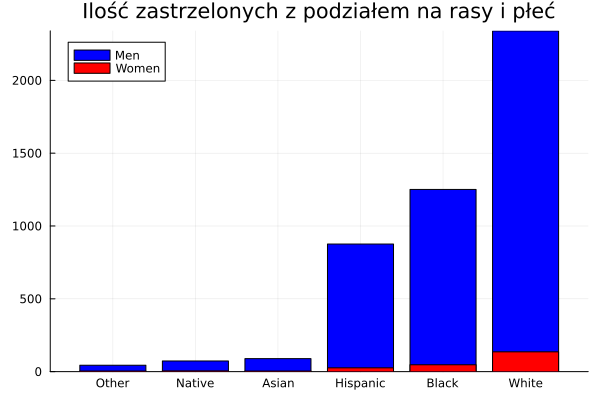

In [3]:
counts_gender = combine(groupby(shootings, :race)) do group
    DataFrame(
        men_shooters = sum(group.gender .== "M"),
        women_shooters = sum(group.gender .== "F")
    )
end

sort!(counts_gender, [:men_shooters, :women_shooters])

bar(counts_gender.race, counts_gender.men_shooters, label="Men", legend=:topleft, color=:blue, title="Ilość zastrzelonych z podziałem na rasy i płeć")
bar!(counts_gender.race, counts_gender.women_shooters, label="Women", color=:red)

Wykres przedstawia procentowy udział osób o danycm kolorze skóry w zestawnienie z całą populacją USA oraz z odsetkiem populalacji osób tej samej rasy. 

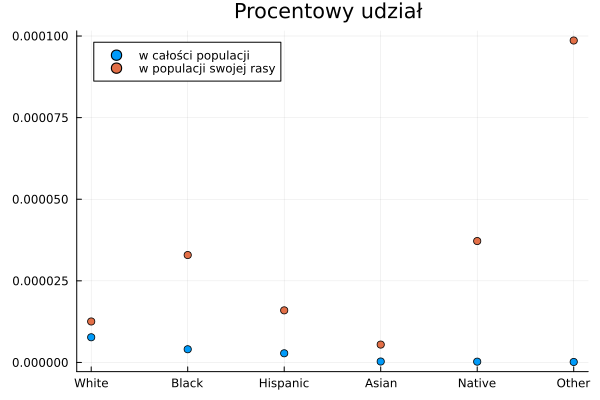

In [4]:
race_counts = combine(groupby(shootings, :race), nrow)

get_shooters(name) = sum(race_counts[race_counts.race .== name, :].nrow)

percentage_shares = DataFrame()
push!(percentage_shares, (race="White", total_share=get_shooters("White")/sum(merged_data.TotalPop), race_share=get_shooters("White")/sum(merged_data.White)))
push!(percentage_shares, (race="Black", total_share=get_shooters("Black")/sum(merged_data.TotalPop), race_share=get_shooters("Black")/sum(merged_data.Black)))
push!(percentage_shares, (race="Hispanic", total_share=get_shooters("Hispanic")/sum(merged_data.TotalPop), race_share=get_shooters("Hispanic")/sum(merged_data.Hispanic)))
push!(percentage_shares, (race="Asian", total_share=get_shooters("Asian")/sum(merged_data.TotalPop), race_share=get_shooters("Asian")/sum(merged_data.Asian)))
push!(percentage_shares, (race="Native", total_share=get_shooters("Native")/sum(merged_data.TotalPop), race_share=get_shooters("Native")/sum(merged_data.Native)))
push!(percentage_shares, (race="Other", total_share=get_shooters("Other")/sum(merged_data.TotalPop), race_share=get_shooters("Other")/sum(merged_data.Pacific)))

scatter(percentage_shares.race, percentage_shares.total_share, label="w całości populacji", title="Procentowy udział ")
scatter!(percentage_shares.race, percentage_shares.race_share, label="w populacji swojej rasy")


Wykres przedstawia wiek ofiar oraz jego statystyczne podsumowanie.

Summary Stats:
Length:         4895
Missing Count:  0
Mean:           36.549750
Std. Deviation: 12.694348
Minimum:        6.000000
1st Quartile:   27.000000
Median:         35.000000
3rd Quartile:   45.000000
Maximum:        91.000000
Type:           Float64
nothing


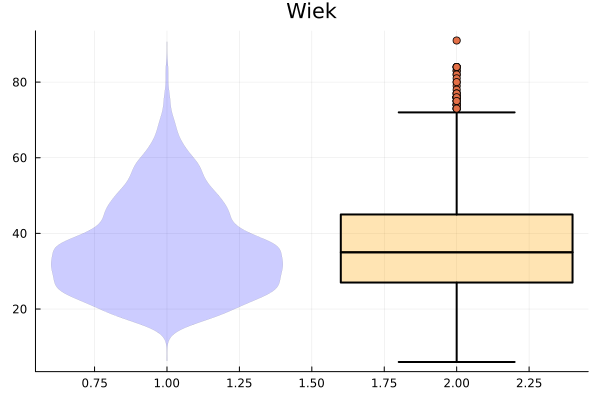

In [5]:
ages = shootings[!, :age]
println(describe(ages))

@df shootings violin(:age, title="Wiek", line=0, fill=(0.2, :blue), label="")
@df shootings boxplot!(:age, line=(2, :black), fill=(0.3, :orange), label="")

Wykres przedstawia zalezność ilości ofiar od całkowitej populacji stanu.

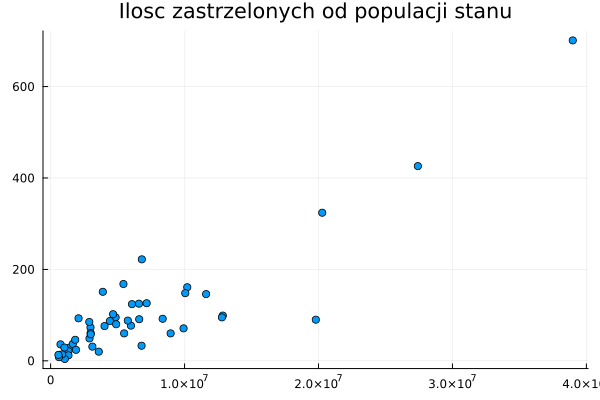

In [6]:
plot(merged_data.TotalPop, merged_data.total_shooters, seriestype=:scatter, label="", title="Ilosc zastrzelonych od populacji stanu")

Utworznie macierzy korelacji na podstawie wybranych zmiennych oraz przedstawienie jej za pomocą heatmapy.

Zmiennne: total_shooters, TotalPop, Hispanic, White, Black, Native, Asian, Pacific, Poverty, ChildPoverty, Unemployment 


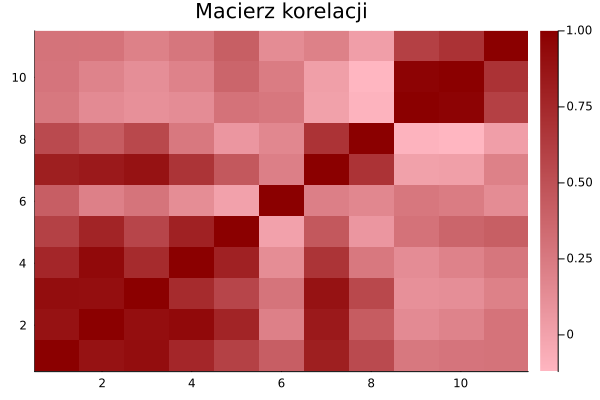

In [7]:
function cormat(df)
    n = ncol(df)
    t = zeros(n, n)
    for i in 1:n
        for j in 1:n
            x = df[!, i]
            y = df[!, j]
            t[i, j] = cor(x, y)
        end
    end
    return t
end

ratios_cols = ["total_shooters","TotalPop", "Hispanic","White","Black","Native","Asian","Pacific","Poverty","ChildPoverty","Unemployment"]
ratios = merged_data[:, ratios_cols]

cor_mat = cormat(ratios)

println("""Zmiennne: total_shooters, TotalPop, Hispanic, White, Black, Native, Asian, Pacific, Poverty, ChildPoverty, Unemployment """)
heatmap(cor_mat, 
        title="Macierz korelacji",
        xlabel="", ylabel="",
        color=:reds)

Wybranie zmiennej opoisującej % osób niezatrudnionych oraz spraawdznie jego wpływu na ilość osób zabitych w strzelaninach z policją.

Wyniki regresji liniowej:[-58.3876440801206, 24.884207582448926]
R^2: 

0.08490973390123124


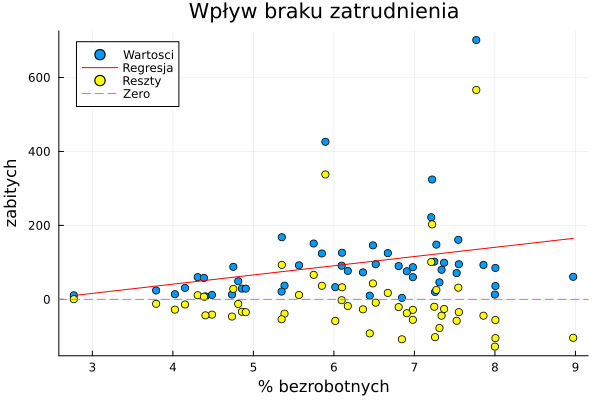

In [6]:
model = lm(@formula(y~x), DataFrame(x=merged_data.Unemployment, y=merged_data.total_shooters))

println("Wyniki regresji liniowej:", coef(model))
println("R^2: ", r2(model))

plot(merged_data.Unemployment, merged_data.total_shooters, seriestype=:scatter, label="Wartosci", title="Wpływ braku zatrudnienia", xlabel="% bezrobotnych", ylabel="zabitych")
plot!(merged_data.Unemployment, predict(model), label="Regresja", color=:red)
residual = residuals(model)
scatter!(merged_data.Unemployment, residual, label="Reszty", color=:yellow)
hline!([0], linestyle=:dash, label="Zero")

Wykres przedstawiający rozkład reszt z regresji liniowej.


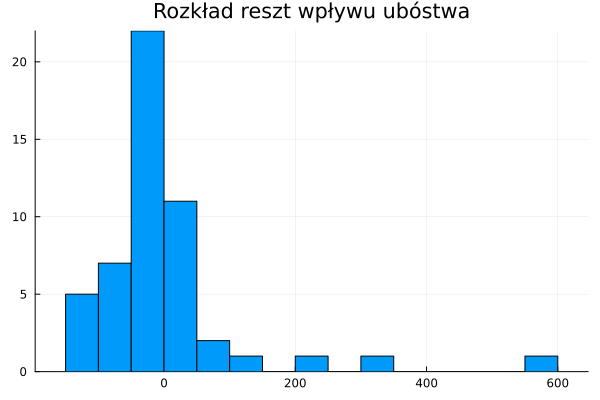

In [9]:
histogram(residual, label="", title="Rozkład reszt wpływu ubóstwa")


Q-Q plot przedstawiajacy zbilezenie poprzedniego rozkładu do rozkładu normalnego.

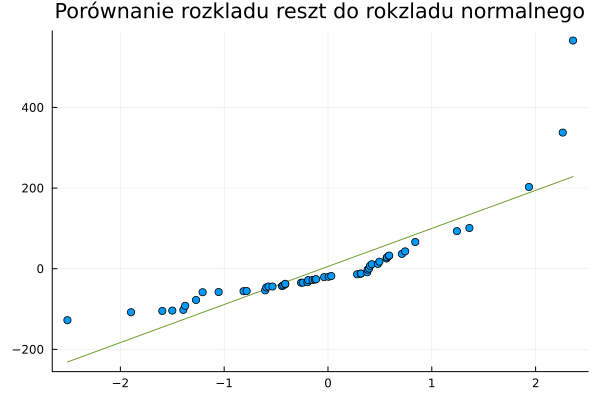

In [10]:
x = rand(Normal(), length(residual))
qqplot(x, residual, qqline=:fit, title="Porównanie rozkladu reszt do rokzladu normalnego")

Autor: Michał Kawa